In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
import torch.nn.functional as F

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
batch_size=16

In [4]:
#training data
traindata=torchvision.datasets.CIFAR10(root="/content/",train=True,download=True,transform=transform)
#train=DataLoader(traindata,batch_size=batch_size,shuffle=True)
#testing data
testdata=torchvision.datasets.CIFAR10(root="/content/",train=False,download=True,transform=transform)
test=DataLoader(testdata,batch_size=batch_size,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
v_size=0.1
data_size=len(traindata)
val_size=int(v_size*data_size)
train_size=data_size-val_size
train_dataset,validation_dataset=random_split(traindata,[train_size,val_size])
train=DataLoader(train_dataset,batch_size=64,shuffle=True)
val=DataLoader(validation_dataset,batch_size=64,shuffle=True)

In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
next(iter(train))

[tensor([[[[ 0.9765,  0.9373,  0.9529,  ...,  0.9765,  0.9765,  0.9765],
           [ 0.4902,  0.5529,  0.7647,  ...,  1.0000,  1.0000,  1.0000],
           [-0.4824, -0.3333,  0.0588,  ...,  0.9529,  0.9922,  0.8980],
           ...,
           [ 1.0000,  0.9529,  0.9451,  ...,  0.9922,  0.9922,  0.9843],
           [ 1.0000,  0.9608,  0.9294,  ...,  0.9843,  0.9922,  0.9843],
           [ 1.0000,  0.9765,  0.9529,  ...,  0.9765,  0.9765,  0.9843]],
 
          [[ 0.9765,  0.9216,  0.9373,  ...,  0.9608,  0.9608,  0.9451],
           [ 0.5608,  0.5843,  0.7725,  ...,  0.9608,  0.9529,  0.9686],
           [-0.2471, -0.1451,  0.2000,  ...,  0.9059,  0.9608,  0.8824],
           ...,
           [ 0.9843,  0.9216,  0.9137,  ...,  0.9529,  0.9608,  0.9608],
           [ 0.9529,  0.9059,  0.8745,  ...,  0.9451,  0.9529,  0.9529],
           [ 0.9686,  0.9373,  0.9216,  ...,  0.9216,  0.9216,  0.9373]],
 
          [[ 0.8980,  0.8824,  0.8824,  ...,  0.9373,  0.9373,  0.9373],
           [ 

In [8]:
def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

In [9]:
dataiter=iter(train)
images,labels=(next(dataiter))

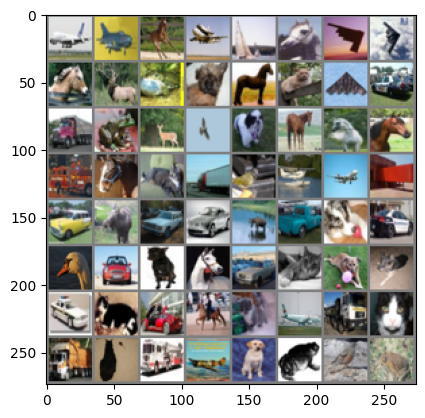

plane plane horse plane ship  horse plane plane horse deer  frog  dog   horse cat   plane car  


In [10]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
class CIFARnet(nn.Module):
  def __init__(self):
    super(CIFARnet, self).__init__()
    self.block1 = nn.Sequential(
            nn.Conv2d(3,32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
          )
    self.block2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12544, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128,10),
            nn.BatchNorm1d(10)
          )
  def forward(self, x):
      x = self.block1(x)
      return self.block2(x)

In [12]:
device=("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [13]:
model=CIFARnet()
model.to(device)

CIFARnet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=10, bias=True)
    (6): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [14]:
learning_rate=1e-4
num_epochs=30

In [15]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.AdamW(model.parameters(),lr=learning_rate)

In [16]:
from sklearn.metrics import accuracy_score

def train_model(model, dataloader, optmizer, loss_fn):
    model.train()
    train_loss, train_acc= 0, 0

    for X, y in dataloader:
        # Forward Pass
        X, y = X.to(torch.device("cuda")), y.to(torch.device("cuda"))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))
        # Back Propagation
        optmizer.zero_grad()
        loss.backward()
        optmizer.step()
        train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc*100:.4f}%")
    return train_loss,train_acc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
def test_model(model, dataloader, optmizer, loss_fn,):
    model.eval()
    test_loss, test_acc= 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))
            test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"test accuracy: {test_acc*100:.2f}%")
    #return test_loss,test_acc    

In [18]:
def val_model(model, dataloader, optmizer, loss_fn):
    model.eval()
    val_loss, val_acc= 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            val_loss += loss_fn(y_pred, y)
            val_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))
            val_loss /= len(dataloader)
        val_acc /= len(dataloader)
        print(f"val loss: {val_loss:.4f} | val accuracy: {val_acc*100:.4f}%")
    return val_loss,val_acc    

In [19]:
train_vals=[]
val_vals=[]
train_loss=[]
train_acc=[]
val_loss=[]
val_acc=[]
for epoch in range(num_epochs):
    print(f"epoch: {epoch}")
    print("--------------------------------------------------------")
    train_vals.append(train_model(model, train, optimizer, loss_fn))
    val_vals.append(val_model(model,val,optimizer,loss_fn))

epoch: 0
--------------------------------------------------------
Train loss: 0.0025 | Train accuracy: 45.2814%
val loss: 0.0243 | val accuracy: 58.1487%
epoch: 1
--------------------------------------------------------
Train loss: 0.0025 | Train accuracy: 57.2021%
val loss: 0.0202 | val accuracy: 63.1922%
epoch: 2
--------------------------------------------------------
Train loss: 0.0017 | Train accuracy: 61.9496%
val loss: 0.0131 | val accuracy: 65.1108%
epoch: 3
--------------------------------------------------------
Train loss: 0.0017 | Train accuracy: 64.4620%
val loss: 0.0093 | val accuracy: 67.1479%
epoch: 4
--------------------------------------------------------
Train loss: 0.0018 | Train accuracy: 66.7014%
val loss: 0.0135 | val accuracy: 67.6622%
epoch: 5
--------------------------------------------------------
Train loss: 0.0019 | Train accuracy: 68.2573%
val loss: 0.0203 | val accuracy: 68.7104%
epoch: 6
--------------------------------------------------------
Train loss

In [20]:
for i in range(len(train_vals)):
    train_loss.append(train_vals[i][0].detach().cpu())
    train_acc.append(train_vals[i][1])
    val_loss.append(val_vals[i][0].detach().cpu())
    val_acc.append(val_vals[i][1])

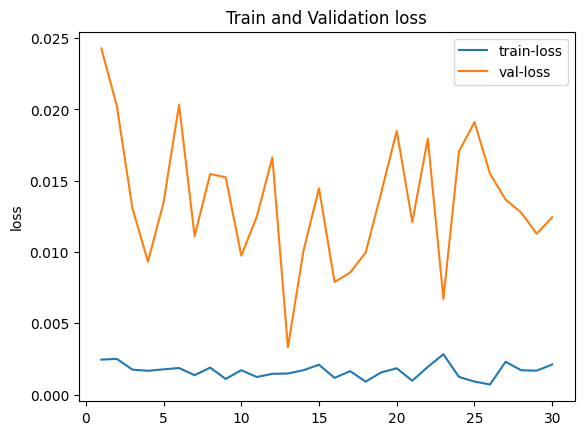

In [21]:
plt.plot(range(1,num_epochs+1),train_loss,label="train-loss")
plt.plot(range(1,num_epochs+1),val_loss,label="val-loss")
plt.ylabel("loss")
plt.legend(loc=1)
plt.title("Train and Validation loss")
plt.show()

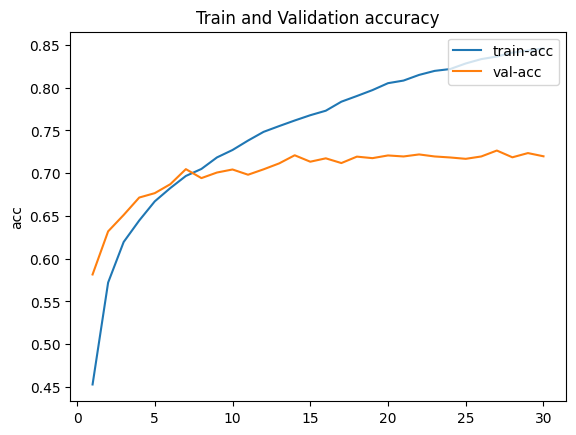

In [22]:
plt.plot(range(1,num_epochs+1),train_acc,label="train-acc")
plt.plot(range(1,num_epochs+1),val_acc,label="val-acc")
plt.ylabel("acc")
plt.title("Train and Validation accuracy")
plt.legend(loc=1)
plt.show()

In [23]:
test_model(model, test, optimizer, loss_fn)

test accuracy: 72.45%
